In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.feature_extraction.text import CountVectorizer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics import f1_score ,precision_score,confusion_matrix,recall_score,accuracy_score ,roc_curve, auc

from gensim.models import Word2Vec , KeyedVectors 

from tqdm import tqdm
import os

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


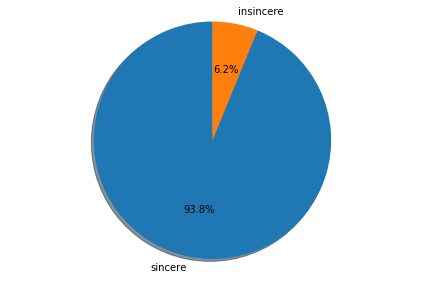

In [4]:
# Pie chart
labels = ['sincere','insincere']
sizes = df_train['target'].value_counts()
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

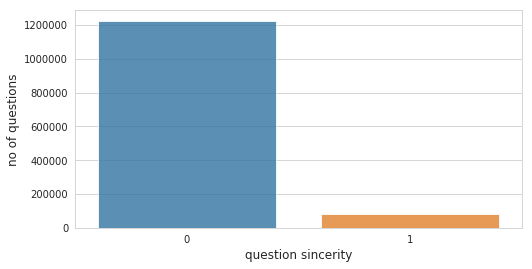

In [51]:
count = df_train['target'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(count.index, count.values, alpha=0.8)
plt.ylabel('no of questions', fontsize=12)
plt.xlabel('question sincerity', fontsize=12)
plt.show()

#### Meta features


In [5]:

df_train["num_words"] = df_train["question_text"].apply(lambda x: len(str(x).split()))
df_test["num_words"] = df_test["question_text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
df_train["num_unique_words"] = df_train["question_text"].apply(lambda x: len(set(str(x).split())))
df_test["num_unique_words"] = df_test["question_text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
df_train["num_chars"] = df_train["question_text"].apply(lambda x: len(str(x)))
df_test["num_chars"] = df_test["question_text"].apply(lambda x: len(str(x)))

## Number of punctuations in the text ##
df_train["num_punctuations"] =df_train['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
df_test["num_punctuations"] =df_test['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
df_train["num_words_upper"] = df_train["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
df_test["num_words_upper"] = df_test["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
df_train["num_words_title"] = df_train["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
df_test["num_words_title"] = df_test["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
df_train["mean_word_len"] = df_train["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test["mean_word_len"] = df_test["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

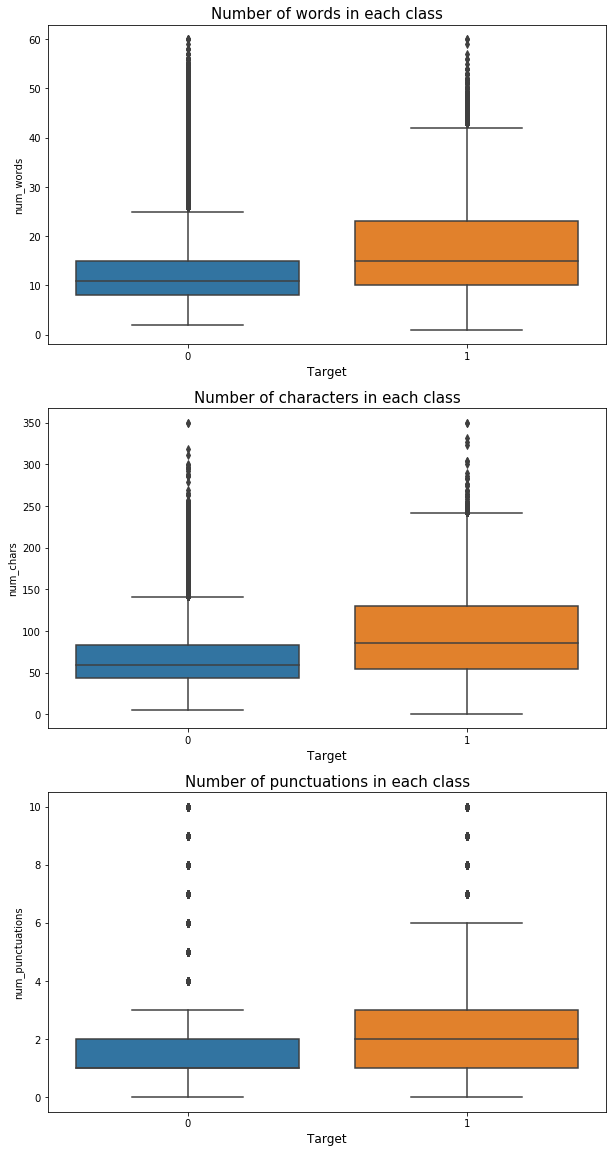

In [6]:
## Truncate some extreme values for better visuals ##
df_train['num_words'].loc[df_train['num_words']>60] = 60 #truncation for better visuals
df_train['num_punctuations'].loc[df_train['num_punctuations']>10] = 10 #truncation for better visuals
df_train['num_chars'].loc[df_train['num_chars']>350] = 350 #truncation for better visuals

f, axes = plt.subplots(3, 1, figsize=(10,20))
sns.boxplot(x='target', y='num_words', data=df_train, ax=axes[0])
axes[0].set_xlabel('Target', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.boxplot(x='target', y='num_chars', data=df_train, ax=axes[1])
axes[1].set_xlabel('Target', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)

sns.boxplot(x='target', y='num_punctuations', data=df_train, ax=axes[2])
axes[2].set_xlabel('Target', fontsize=12)
#plt.ylabel('Number of punctuations in text', fontsize=12)
axes[2].set_title("Number of punctuations in each class", fontsize=15)
plt.show()

In [53]:
df_train.columns

Index(['qid', 'question_text', 'target', 'num_words', 'num_unique_words',
       'num_chars', 'num_punctuations', 'num_words_upper', 'num_words_title',
       'mean_word_len'],
      dtype='object')

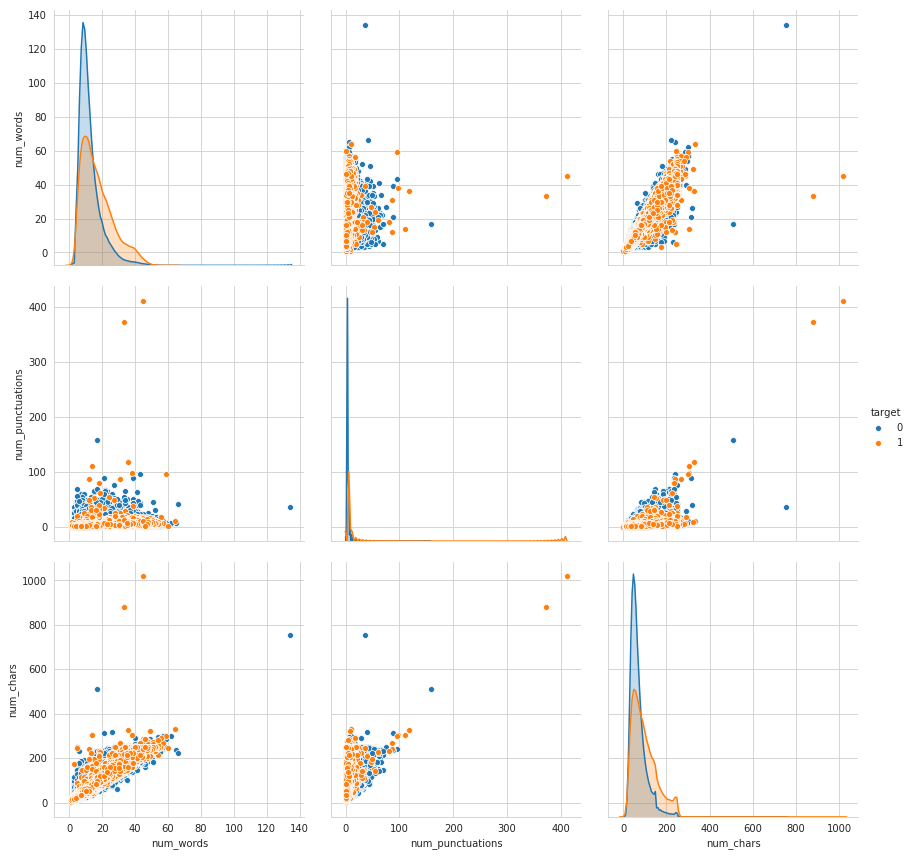

In [54]:
plt.close();
sns.set_style("whitegrid");
sns.pairplot(df_train[['num_words','num_punctuations','num_chars','target']],hue='target', height=4,vars=['num_words','num_punctuations','num_chars'] );
plt.show()



Some features looks useful we will use them to our model and will see if model improves using them

In [7]:
df_train.head()

,qid,question_text,target,num_words,num_unique_words,num_chars,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,13,72,1,0,2,4.615385
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16,15,81,2,0,1,4.125000
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,10,8,67,2,0,2,5.800000
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,9,9,57,1,0,4,5.444444
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,15,15,77,1,2,3,4.200000


#### data splitting 

In [8]:
df_train.columns

Index(['qid', 'question_text', 'target', 'num_words', 'num_unique_words',
       'num_chars', 'num_punctuations', 'num_words_upper', 'num_words_title',
       'mean_word_len'],
      dtype='object')

In [9]:
from sklearn.model_selection import train_test_split 

features = ['qid', 'question_text', 'num_words', 'num_unique_words',
       'num_chars', 'num_punctuations', 'num_words_upper',
       'num_words_title', 'mean_word_len']
X_tr, X_cv, y_tr, y_cv = train_test_split(df_train[features], df_train['target'], test_size=0.3, random_state=5)


In [10]:
X_tr.head()

,qid,question_text,num_words,num_unique_words,num_chars,num_punctuations,num_words_upper,num_words_title,mean_word_len
678845,84f2086602bdeae41802,What was the aftermath of the Vietnam War and ...,14,12,79,2,0,5,4.714286
213067,29abd6b1c7539b03add6,What kind of bias is it when an investor recom...,15,15,89,1,0,1,5.000000
855040,a7883322b79642c254f5,How is the physiological concentration of a dr...,13,13,90,1,0,1,6.000000
26108,051d89fa83041ff757cd,My partner's IQ is 162 but is terrible in bed....,14,13,61,3,2,3,3.428571
126721,18cb970a7bfd59adddbe,What are some vintage rock and roll music?,8,8,42,1,0,1,4.375000


### Bag of words

In [12]:
#Creating bag of words and vectorizing it
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(ngram_range=(1,2),max_features=50000,dtype=float) 
final_counts_tr = count_vect.fit_transform(X_tr['question_text'].values)
final_counts_cv = count_vect.transform(X_cv['question_text'].values)

In [13]:
print("shape for the bag of words train data is ",final_counts_tr.shape)
print("shape for the bag of words cv data is ",final_counts_cv.shape)

shape for the bag of words train data is  (914285, 50000)
shape for the bag of words cv data is  (391837, 50000)


## SGD classifier

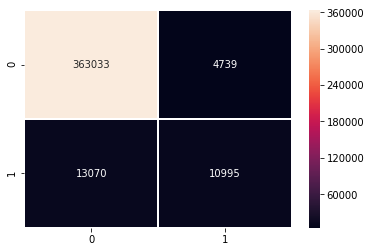

The best parameters are {'penalty': 'l2', 'alpha': 1e-05} with a score of 0.56
Accuracy on cv set for BoW: 95.455%
Precision on cv set for BoW: 0.699
Recall on cv set for BoW: 0.457
F1-Score on cv set for BoW: 0.553


In [14]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
tuned_parameters ={'penalty':['l1','l2','elasticnet'],
             'alpha':[500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]} 
model = RandomizedSearchCV(SGDClassifier(),param_distributions=tuned_parameters,n_jobs = -1,scoring='f1')
model.fit(final_counts_tr, y_tr)
pred=model.predict(final_counts_cv)
conf_mat = confusion_matrix(y_cv,pred)
sns.heatmap(conf_mat,annot=True,fmt="d",linewidths=.5)
plt.show()

print("The best parameters are %s with a score of %0.2f"
      % (model.best_params_, model.best_score_))

print("Accuracy on cv set for BoW: %0.3f%%"%(accuracy_score(y_cv, pred)*100))
print("Precision on cv set for BoW: %0.3f"%(precision_score(y_cv, pred)))
print("Recall on cv set for BoW: %0.3f"%(recall_score(y_cv, pred)))
print("F1-Score on cv set for BoW: %0.3f"%(f1_score(y_cv, pred)))

In [15]:
model = SGDClassifier(penalty='l2',alpha=1e-05)
model.fit(final_counts_tr,y_tr)

SGDClassifier(alpha=1e-05, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

### word cloud for insincere questions

In [16]:
words = count_vect.get_feature_names()
likelihood_df = pd.DataFrame(model.coef_.transpose(),columns=[ 'Score'],index=words)
top_100_insincere = likelihood_df.sort_values(by='Score',ascending=False).iloc[:100]
top_100_insincere.reset_index(inplace=True)
top_words_insincere = top_100_insincere['index']

In [17]:
top_words_insincere

0         castrated
1          castrate
2        castration
3            incest
4            idiots
5       homosexuals
6              fuck
7             moron
8              gays
9            blacks
10            pussy
11         liberals
12        feminists
13          asshole
14           fucked
15           bhakts
16            raped
17          fucking
18           nibiru
19              jew
20           whites
21         shithole
22         bullshit
23            aunty
24    homosexuality
25         assholes
26             cunt
27             shit
28             sjws
29          muslims
          ...      
70        civilized
71          blowjob
72            serbs
73        apartheid
74           hindus
75        europeans
76     palestinians
77       pedophilia
78          traitor
79       pakistanis
80            kurds
81          mormons
82             piss
83        filipinos
84          indians
85         murdered
86         nonsense
87           it gay
88         atheists


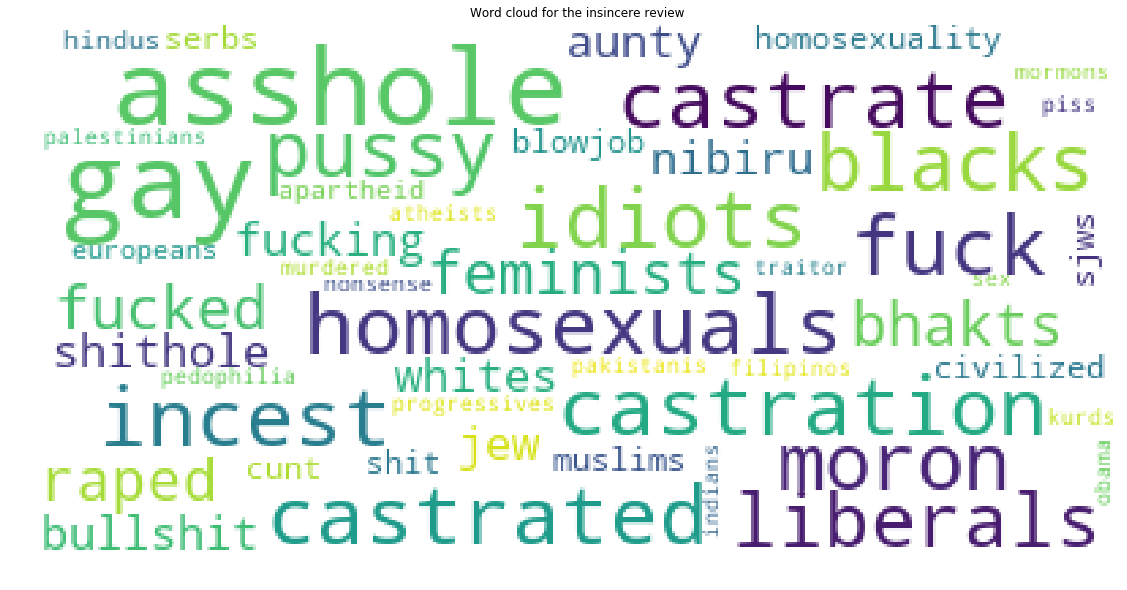

In [18]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white',
                        max_words=50,
                          max_font_size=40, 
                          random_state=42,
                         ).generate(str(top_words_insincere))
print(wordcloud)
fig = plt.figure(1,figsize=(20,10))
plt.title("Word cloud for the insincere review")
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### word cloud for sincere questions

In [19]:
words = count_vect.get_feature_names()
likelihood_df = pd.DataFrame(model.coef_.transpose(),columns=[ 'Score'],index=words)
top_100_sincere = likelihood_df.sort_values(by='Score',ascending=True).iloc[:100]
top_100_sincere.reset_index(inplace=True)
top_words_sincere = top_100_sincere['index']

In [20]:
top_words_sincere

0           non muslims
1           for indians
2          muslim women
3            girls hate
4            did hitler
5            see people
6             confident
7             do always
8              gay porn
9            stupid and
10        and democrats
11          legislation
12         and liberals
13          in american
14         with another
15              does my
16                yemen
17              rise in
18       biased against
19            do people
20    and conservatives
21            woman who
22              do deal
23              do hate
24          many people
25             like men
26           with women
27            get along
28              we hear
29                 zeus
            ...        
70               triple
71              do keep
72              he only
73         wonder woman
74           that these
75               verbal
76          and muslims
77         if president
78       christians and
79          black money
80              

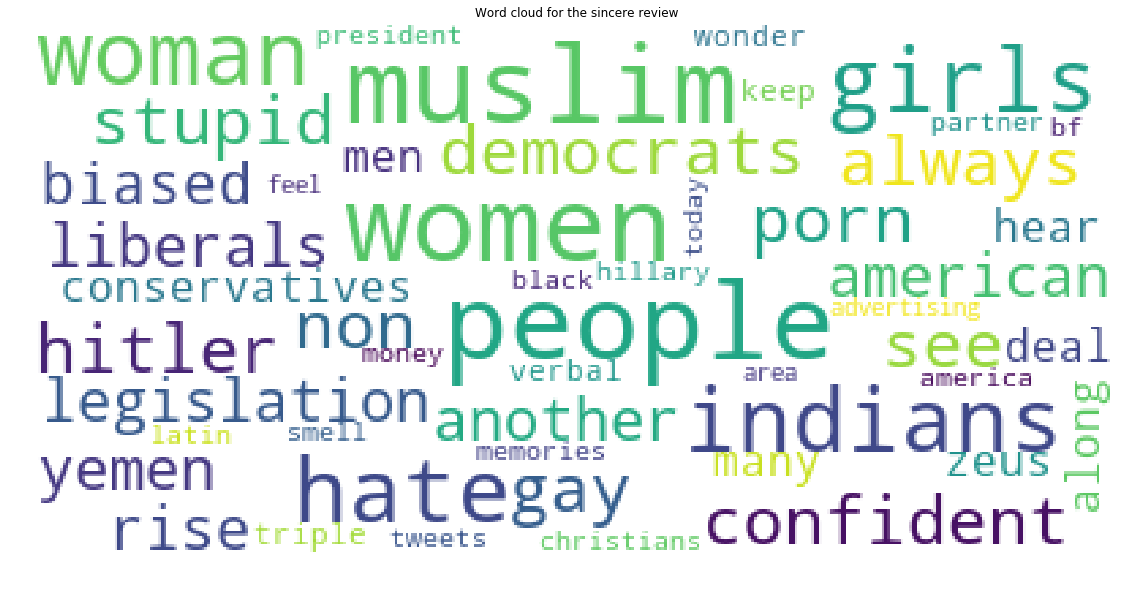

In [21]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white',
                        max_words=50,
                          max_font_size=40, 
                          random_state=42,
                         ).generate(str(top_words_sincere))
print(wordcloud)
fig = plt.figure(1,figsize=(20,10))
plt.title("Word cloud for the sincere review")
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Naive Bayes

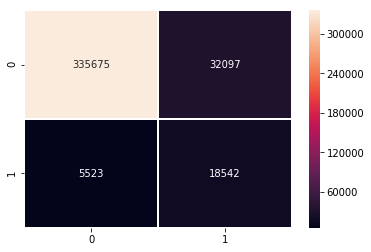

The best parameters are {'alpha': 0.0005} with a score of 0.50
Accuracy on cv set for bag of words Naive Bayes: 90.399%
Precision on cv set for bag of words Naive Bayes: 0.366
Recall on cv set for bag of words Naive Bayes: 0.770
F1-Score on cv set for bag of words Naive Bayes: 0.496


In [22]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import BernoulliNB
tuned_parameters ={ 'alpha':[0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]} 
model = RandomizedSearchCV(BernoulliNB(),param_distributions=tuned_parameters,n_jobs = -1,scoring='f1')
model.fit(final_counts_tr, y_tr)
pred=model.predict(final_counts_cv)
conf_mat = confusion_matrix(y_cv,pred)
sns.heatmap(conf_mat,annot=True,fmt="d",linewidths=.5)
plt.show()

print("The best parameters are %s with a score of %0.2f"
      % (model.best_params_, model.best_score_))

print("Accuracy on cv set for bag of words Naive Bayes: %0.3f%%"%(accuracy_score(y_cv, pred)*100))
print("Precision on cv set for bag of words Naive Bayes: %0.3f"%(precision_score(y_cv, pred)))
print("Recall on cv set for bag of words Naive Bayes: %0.3f"%(recall_score(y_cv, pred)))
print("F1-Score on cv set for bag of words Naive Bayes: %0.3f"%(f1_score(y_cv, pred)))

# TF-IDF

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(max_features=50000)
tf_idf_tr = tf_idf_vect.fit_transform(X_tr['question_text'].values)
tf_idf_cv = tf_idf_vect.transform(X_cv['question_text'].values)

In [24]:
tf_idf_cv.shape

(391837, 50000)

## SGD classifier tf-idf

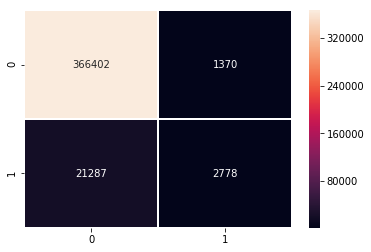

The best parameters are {'penalty': 'l1', 'alpha': 5e-05} with a score of 0.19
Accuracy on cv set for tf-idf: 94.218%
Precision on cv set for tf-idf: 0.670
Recall on cv set for tf-idf: 0.115
F1-Score on cv set for tf-idf: 0.197


In [26]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
tuned_parameters ={'penalty':['l1','l2','elasticnet'],
             'alpha':[500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]} 
model = RandomizedSearchCV(SGDClassifier(),param_distributions=tuned_parameters,n_jobs = -1,scoring='f1')
model.fit(tf_idf_tr, y_tr)
pred=model.predict(tf_idf_cv)
conf_mat = confusion_matrix(y_cv,pred)
sns.heatmap(conf_mat,annot=True,fmt="d",linewidths=.5)
plt.show()

print("The best parameters are %s with a score of %0.2f"
      % (model.best_params_, model.best_score_))

print("Accuracy on cv set for tf-idf: %0.3f%%"%(accuracy_score(y_cv, pred)*100))
print("Precision on cv set for tf-idf: %0.3f"%(precision_score(y_cv, pred)))
print("Recall on cv set for tf-idf: %0.3f"%(recall_score(y_cv, pred)))
print("F1-Score on cv set for tf-idf: %0.3f"%(f1_score(y_cv, pred)))

### Naive Bayes

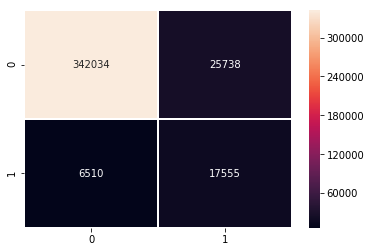

The best parameters are {'alpha': 0.05} with a score of 0.52
Accuracy on cv set for tf-idf: 91.770%
Precision on cv set for tf-idf: 0.405
Recall on cv set for tf-idf: 0.729
F1-Score on cv set for tf-idf: 0.521


In [27]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import BernoulliNB
tuned_parameters ={ 'alpha':[0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]} 
model = RandomizedSearchCV(BernoulliNB(),param_distributions=tuned_parameters,n_jobs = -1,scoring='f1')
model.fit(tf_idf_tr, y_tr)
pred=model.predict(tf_idf_cv)
conf_mat = confusion_matrix(y_cv,pred)
sns.heatmap(conf_mat,annot=True,fmt="d",linewidths=.5)
plt.show()

print("The best parameters are %s with a score of %0.2f"
      % (model.best_params_, model.best_score_))

print("Accuracy on cv set for tf-idf: %0.3f%%"%(accuracy_score(y_cv, pred)*100))
print("Precision on cv set for tf-idf: %0.3f"%(precision_score(y_cv, pred)))
print("Recall on cv set for tf-idf: %0.3f"%(recall_score(y_cv, pred)))
print("F1-Score on cv set for tf-idf: %0.3f"%(f1_score(y_cv, pred)))

In [28]:
nb_model = BernoulliNB(alpha=0.0001)
nb_model.fit(tf_idf_tr, y_tr)

BernoulliNB(alpha=0.0001, binarize=0.0, class_prior=None, fit_prior=True)

In [29]:
words = tf_idf_vect.get_feature_names()
likelihood_df = pd.DataFrame(nb_model.feature_log_prob_.transpose(),columns=['Sincere','Insincere'],index=words)
likelihood_df = likelihood_df.eval('(exp(Sincere) - exp(Insincere))')

In [30]:
top_100_sincere = likelihood_df.sort_values(ascending=False).iloc[:100]
top_100_sincere

what           0.263810
how            0.113178
can            0.049748
best           0.041660
in             0.036752
you            0.036013
which          0.033322
is             0.026715
for            0.023576
your           0.021741
my             0.018931
some           0.017203
good           0.012128
between        0.011814
where          0.009948
get            0.009917
job            0.007758
work           0.007743
engineering    0.007718
difference     0.007711
life           0.006636
online         0.006630
someone        0.006546
company        0.006277
college        0.006206
after          0.006128
business       0.006099
book           0.005960
study          0.005919
learn          0.005885
                 ...   
account        0.003093
website        0.003043
engineer       0.003021
process        0.002970
examples       0.002923
market         0.002897
google         0.002883
way            0.002866
major          0.002839
movie          0.002831
car            0

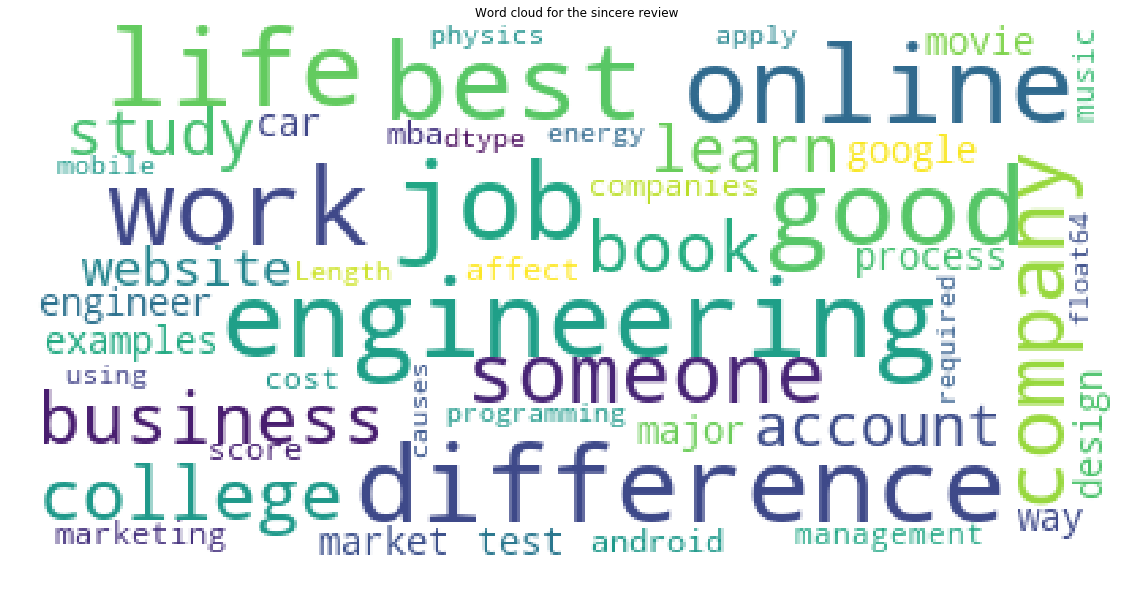

In [31]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white',
                        max_words=50,
                          max_font_size=40, 
                          random_state=42,
                         ).generate(str(top_100_sincere))
print(wordcloud)
fig = plt.figure(1,figsize=(20,10))
plt.title("Word cloud for the sincere review")
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [32]:
top_100_insincere = likelihood_df.sort_values(ascending=True).iloc[:100]
top_100_insincere

why          -0.325749
and          -0.118718
that         -0.108847
people       -0.107564
do           -0.107059
they         -0.103293
to           -0.091501
so           -0.085316
are          -0.081515
their        -0.073076
trump        -0.068611
women        -0.060102
it           -0.057564
not          -0.048327
men          -0.042159
with         -0.041587
have         -0.040433
white        -0.038394
muslims      -0.038101
all          -0.037322
as           -0.035744
don          -0.035255
like         -0.035079
when         -0.034879
americans    -0.032394
them         -0.031660
quora        -0.029726
than         -0.029416
by           -0.029037
black        -0.029011
                ...   
democrats    -0.015421
only         -0.015113
even         -0.015102
obama        -0.014328
believe      -0.014163
racist       -0.013952
most         -0.013543
no           -0.013239
india        -0.012976
true         -0.012928
has          -0.012836
christians   -0.012721
such       

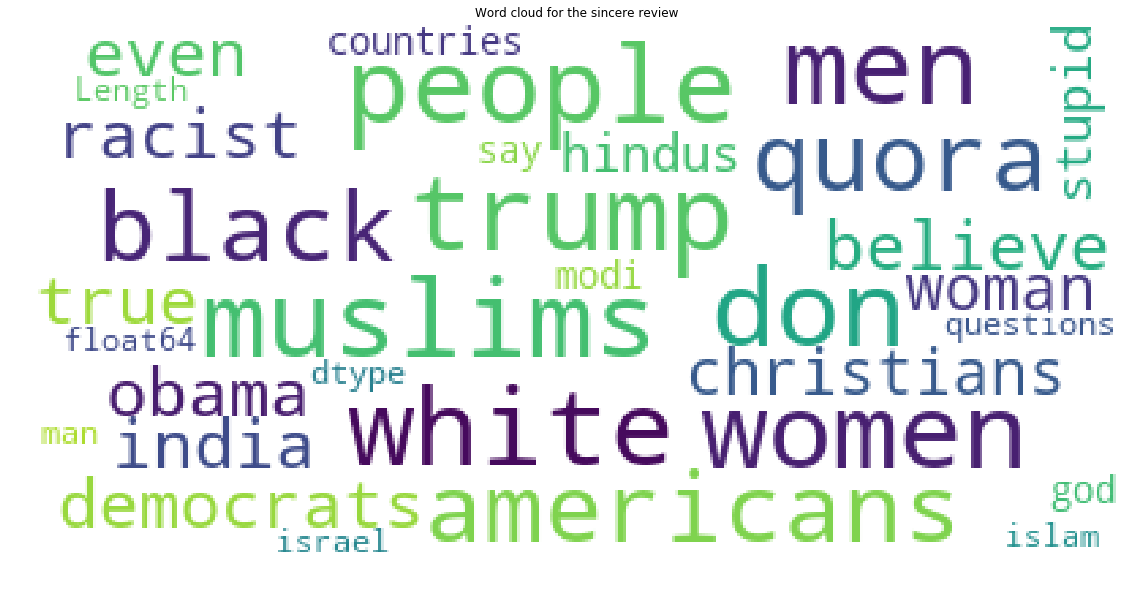

In [33]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white',
                        max_words=50,
                          max_font_size=40, 
                          random_state=42,
                         ).generate(str(top_100_insincere))
print(wordcloud)
fig = plt.figure(1,figsize=(20,10))
plt.title("Word cloud for the sincere review")
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### decision tree

In [90]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [87]:
depth = [x for x in range(1, 40,5)]
depth

[1, 6, 11, 16, 21, 26, 31, 36]

In [92]:
cv_scores = []
for d in depth:
    clf = DecisionTreeClassifier(max_depth = d,max_features=2000)
    scores = cross_val_score(clf, tf_idf_tr, y_tr, cv=3, scoring='f1')
    cv_scores.append(scores.mean())

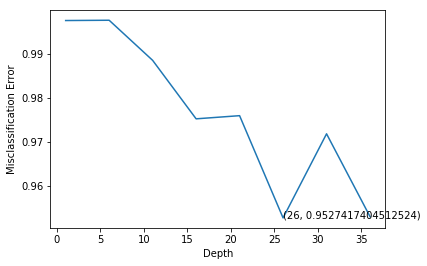

In [93]:
error = [1 - x for x in cv_scores]
optimal_depth = depth[error.index(min(error))]
plt.plot(depth, error)
xy = (optimal_depth, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Depth")
plt.ylabel("Misclassification Error")
plt.show()

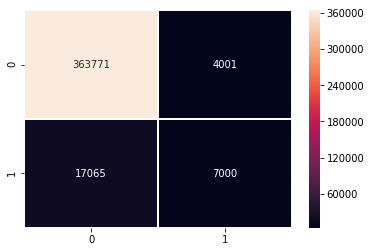

Accuracy on cv set for tf-idf: 94.624%
Precision on cv set for tf-idf: 0.636
Recall on cv set for tf-idf: 0.291
F1-Score on cv set for tf-idf: 0.399


In [95]:
model = DecisionTreeClassifier(max_depth = optimal_depth) # MAx depth obtained from CV.
model.fit(tf_idf_tr, y_tr)
pred=model.predict(tf_idf_cv)
conf_mat = confusion_matrix(y_cv,pred)
sns.heatmap(conf_mat,annot=True,fmt="d",linewidths=.5)
plt.show()

print("Accuracy on cv set for tf-idf: %0.3f%%"%(accuracy_score(y_cv, pred)*100))
print("Precision on cv set for tf-idf: %0.3f"%(precision_score(y_cv, pred)))
print("Recall on cv set for tf-idf: %0.3f"%(recall_score(y_cv, pred)))
print("F1-Score on cv set for tf-idf: %0.3f"%(f1_score(y_cv, pred)))